1. Set up Super Mario

In [1]:
# Import the game
import gym_super_mario_bros
# Import the joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
# Setup game
env =  gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# 2. Bucle principal de pasos en el entorno
# En la API antigua se esperan 4 valores: observación, recompensa, done, info.
done = True  # Inicializamos la variable 'done'

for step in range(100000):
    # Si el episodio anterior terminó, reiniciamos el entorno
    if done:
        env.reset()
    
    # 3. Ejecutamos un paso en el entorno y obtenemos:
    #    - state: la nueva observación
    #    - reward: la recompensa obtenida
    #    - done: indica si el episodio terminó
    #    - info: diccionario con información extra del paso
    state, reward, done, info = env.step(env.action_space.sample())
    
    # 4. Renderizamos para visualizar lo que ocurre en la pantalla
    env.render()

# 5. Cerramos el entorno al finalizar el bucle
env.close()

c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\utils\passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more informati

KeyboardInterrupt: 

In [4]:
env.close()

2. Preprocess Environment

In [ ]:
# Framestack permite 'guardar' varios frames para que el modelo tenga contexto
# GrayScale permite cambiar los colores de la imagen a Blanco y negro
from gym.wrappers import GrayScaleObservation

# Importo los wrappers para poder vectorizar mis datos
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Show the impact of frame stacking
import matplotlib.pyplot as plt

In [ ]:
# Crear el environment
env =  gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplificar los controles originales
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Convertir la imagen en escala de grises
env = GrayScaleObservation(env, keep_dim=True)
# Wrap en el env ([dummy
env = DummyVecEnv([lambda: env]) # Se utiliza una funcion lambda, DummyVecEnv recibe funciones e inicializa en entorno cuando lo necesita, se pueden instanciar mas entornos usando mas funciones lambda
# Stackear los frames
env = VecFrameStack(env, 4, channels_order='last')

c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Carlos\anaconda3\envs\mario_env\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [16]:
state = env.reset()

In [17]:
state.shape

(240, 256, 1)

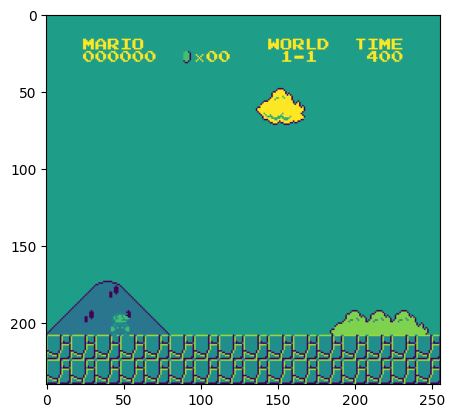

In [18]:
plt.imshow(state)

3. Train the RL Model

4. Test it out